<a href="https://colab.research.google.com/github/frankl1/Introduction-to-Tensorflow-for-Deep-Learning/blob/master/Cats_vs_Dogs_With_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
try:
  %tensorflow_version 2.x
except:
  pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import logging

In [0]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Loading data

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dataset = tf.keras.utils.get_file("cats_and_dogs_filtered.zip", _URL, extract=True)

68608000/68606236 [==============================] - 2s 0us/step


In [5]:
zip_dir = os.path.dirname(zip_dataset)
!find $zip_dir -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [0]:
base_dir = os.path.join(zip_dir, "cats_and_dogs_filtered")

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")

train_cats_dir = os.path.join(train_dir, "cats")
train_dogs_dir = os.path.join(train_dir, "dogs")

val_cats_dir = os.path.join(val_dir, "cats")
val_dogs_dir = os.path.join(val_dir, "dogs")

# Understanding the dataset

In [7]:
nb_train_cats = len(os.listdir(train_cats_dir))
nb_train_dogs = len(os.listdir(train_dogs_dir))
nb_val_cats = len(os.listdir(val_cats_dir))
nb_val_dogs = len(os.listdir(val_dogs_dir))
nb_train = nb_train_cats + nb_train_dogs
nb_val = nb_val_cats + nb_val_dogs

print("total train cat images:", nb_train_cats)
print("total train dog images:", nb_train_dogs)
print("total validation cat images:", nb_val_cats)
print("totoal validation dog images:", nb_val_dogs)
print("--")
print("total train:", nb_train)
print("total validation:", nb_val)

total train cat images: 1000
total train dog images: 1000
total validation cat images: 500
totoal validation dog images: 500
--
total train: 2000
total validation: 1000


# Parameters

In [0]:
BATCH_SIZE = 100
IMG_SHAPE = 150
EPOCHS = 10

# Data preparation

In [0]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0, 
    rotation_range=45, 
    zoom_range=0.5,
    fill_mode="nearest",
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

In [31]:
train_data_gen = train_image_generator.flow_from_directory(train_dir,batch_size=BATCH_SIZE, shuffle=True, target_size=(IMG_SHAPE, IMG_SHAPE), class_mode="binary")

Found 2000 images belonging to 2 classes.


In [0]:
val_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)

In [12]:
val_data_gen = train_image_generator.flow_from_directory(val_dir, target_size=(IMG_SHAPE, IMG_SHAPE), class_mode="binary", shuffle=False, batch_size=BATCH_SIZE)

Found 1000 images belonging to 2 classes.


# Dataviz

In [0]:
def plot_images(images):
  fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
  for image, ax in zip(images[:5], axes):
    ax.imshow(image)
  plt.show()

In [0]:
sample_train_image = [train_data_gen[0][0][0] for i in range(5)]

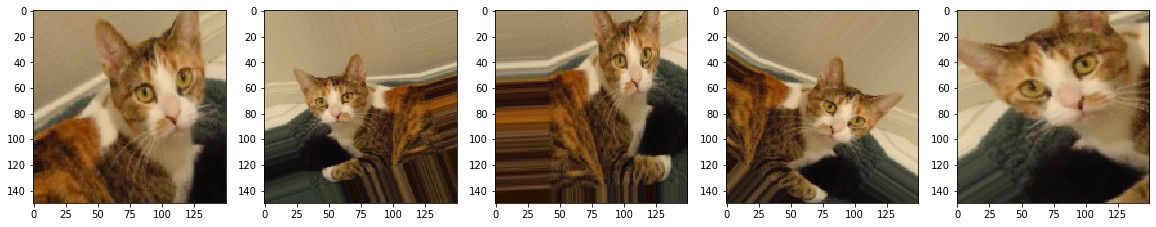

In [33]:
plot_images(sample_train_image)

# Model creation


## defining the model

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
  tf.keras.layers.MaxPool2D((2, 2), strides=2),

  tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
  tf.keras.layers.MaxPool2D((2, 2), strides=2),

  tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
  tf.keras.layers.MaxPool2D((2, 2), strides=2),

  tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
  tf.keras.layers.MaxPool2D((2, 2), strides=2),

  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dense(2, activation="softmax")
])

## model compilation

In [0]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

## Training the model


In [38]:
history = model.fit_generator(
    train_data_gen, 
    steps_per_epoch=np.ceil(nb_train / BATCH_SIZE), 
    validation_data=val_data_gen, 
    epochs=EPOCHS, 
    validation_steps=np.ceil(nb_val / BATCH_SIZE),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)])

Epoch 1/10
20/20 [==============================] - 18s 893ms/step - loss: 0.5710 - accuracy: 0.6975 - val_loss: 0.5061 - val_accuracy: 0.7510
Epoch 2/10
20/20 [==============================] - 16s 789ms/step - loss: 0.5544 - accuracy: 0.7145 - val_loss: 0.4979 - val_accuracy: 0.7400
Epoch 3/10
20/20 [==============================] - 16s 785ms/step - loss: 0.5479 - accuracy: 0.7265 - val_loss: 0.5231 - val_accuracy: 0.7430
Epoch 4/10
20/20 [==============================] - 16s 792ms/step - loss: 0.5389 - accuracy: 0.7430 - val_loss: 0.4898 - val_accuracy: 0.7550
Epoch 5/10
20/20 [==============================] - 16s 793ms/step - loss: 0.5324 - accuracy: 0.7390 - val_loss: 0.5066 - val_accuracy: 0.7590
Epoch 6/10
20/20 [==============================] - 16s 794ms/step - loss: 0.5257 - accuracy: 0.7265 - val_loss: 0.4870 - val_accuracy: 0.7620
Epoch 7/10
20/20 [==============================] - 16s 787ms/step - loss: 0.5269 - accuracy: 0.7465 - val_loss: 0.5003 - val_accuracy: 0.7450

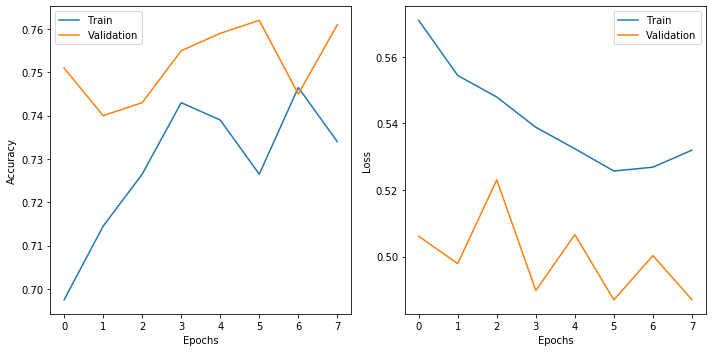

In [40]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot(train_acc, label="Train")
axes[0].plot(val_acc, label="Validation")
axes[0].legend()
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")

axes[1].plot(train_loss, label="Train")
axes[1].plot(val_loss, label="Validation")
axes[1].legend()
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")

fig.tight_layout()